Встановимо модулі, які нам знадобляться для a/b test

In [162]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import random
import statsmodels.stats.api as sms
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm

In [3]:
df = pd.read_csv('ab_data.csv')

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Бачимо data frame, який містять результат A/B тесту (маємо групу А - control і B - treatment). Метою цього тесту було визначити, чи нова веб-сторінка призвела до значного збільшення конверсій порівняно зі старою веб-сторінкою.
Звідси можемо висунути нульову і альтернативну гіпотезу:
H0: Немає значної різниці між старою і новою веб-сторінками щодо конверсій.
H1: Нова веб-сторінка призвела до значного збільшення конверсій порівняно зі старою веб-сторінкою.

Тепер перевіримо дані

In [6]:
df.shape

(294478, 5)

In [7]:
df[['user_id', 'timestamp']].nunique()

user_id      290584
timestamp    294478
dtype: int64

In [4]:
df.groupby(['group','landing_page'])[['user_id', 'timestamp']].count()

user_id  timestamp
group     landing_page                    
control   new_page         1928       1928
          old_page       145274     145274
treatment new_page       145311     145311
          old_page         1965       1965

Бачимо, що control група бачила нову сторінку, так само treatment бачила стару сторінку. Можемо зробити висновки, щоб відбулась помилка класифікації, то такі краще видалити. 

In [5]:
df.drop(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].index, inplace=True)

In [6]:
df.drop(df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].index, inplace=True)

In [7]:
df.groupby(['group','landing_page'])[['user_id', 'timestamp']].count()

,,user_id,timestamp
group,landing_page,,
control,old_page,145274,145274
treatment,new_page,145311,145311


In [8]:
df.shape

(290585, 5)

In [9]:
df[['user_id', 'timestamp']].nunique()

user_id      290584
timestamp    290585
dtype: int64

Вже краще, тепер перевіримо, чи є рядки дублікати і чи містять рядки із значенням Nan

In [10]:
df.duplicated().sum()

0

In [11]:
df[['user_id']].duplicated().sum()

1

Цікаво
Глянемо, що то рядки і чи потрібно видалити.

In [12]:
df[df.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Так як в колонці converted обидва значення дорівнюють нулеві, то може мо видалити один із них.

In [13]:
df.drop_duplicates(subset=['user_id'], keep='first', inplace=True)

In [14]:
df[(df['user_id'] == 773192)] 

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [15]:
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [21]:
df.groupby(['group','landing_page'])['user_id'].nunique()

group      landing_page
control    old_page        145274
treatment  new_page        145274
Name: user_id, dtype: int64

Тепер можемо переходити до аналіз даного, якщо можна сказати до найсмачнішого.

In [44]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f') 

In [45]:
df['date'] = df['timestamp'].dt.date

In [50]:
df_control = df[df['group'] == 'control'].groupby('date')['converted'].sum().reset_index()

In [52]:
df_treatment = df[df['group'] == 'treatment'].groupby('date')['converted'].sum().reset_index()

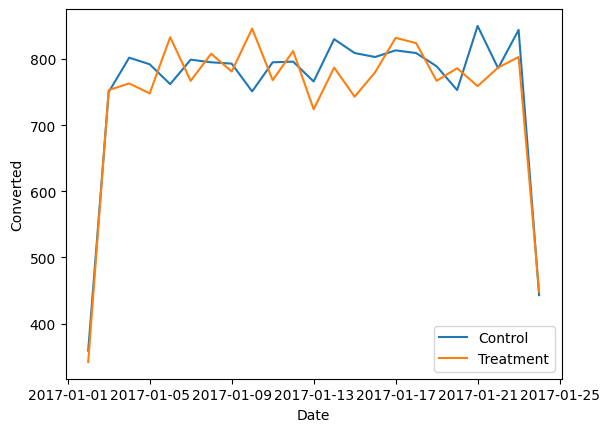

In [53]:
plt.plot(df_control['date'], df_control['converted'], label='Control')
plt.plot(df_treatment['date'], df_treatment['converted'], label='Treatment')
plt.xlabel('Date')
plt.ylabel('Converted')
plt.legend()
plt.show()

Поргупували за датаю та бачимо, як змінюється конверсія. По графіку можемо помітити, що суттєвою різниці немає між групами, але на початку користування нова сторінка трішки краще вплинула на ситуацію і згодом вона змінилась. Настпуним кроком обрахуємо кількість учасників кожної групи потрбіно з рівнем значущості 0.05 і статестичною потужностю 0.8. Стосовно розміру ефекту – наскільки велика різниця, яку ми очікуємо, буде між коефіцієнтами конверсії. Нехай різницею в 2%, ми можемо використовувати 13% і 15% для розрахунку очікуваного розміру ефекту.

In [106]:
effect_size = sms.proportion_effectsize(0.12, 0.14)
alpha = 0.05
power = 0.8
sample_size = sms.NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=1)
count_drop = round(sample_size)
count_drop

4432

In [110]:
treatment_indexes = df[df['group'] == 'treatment'].index.tolist()
random_indexes = random.sample(treatment_indexes, len(treatment_indexes) - count_drop)
df = df.drop(random_indexes)

In [111]:
treatment_indexes = df[df['group'] == 'control'].index.tolist()
random_indexes = random.sample(treatment_indexes, len(treatment_indexes)-count_drop)
df = df.drop(random_indexes)

In [114]:
df.groupby(['group','landing_page'])[['user_id', 'timestamp']].count()

,,user_id,timestamp
group,landing_page,,
control,old_page,4432,4432
treatment,new_page,4432,4432


Можна додати, що різна кількість учасників могла б вплинути на статистичну потужність тесту та на точність результатів. Тепер сміло переходимо до аналізу.

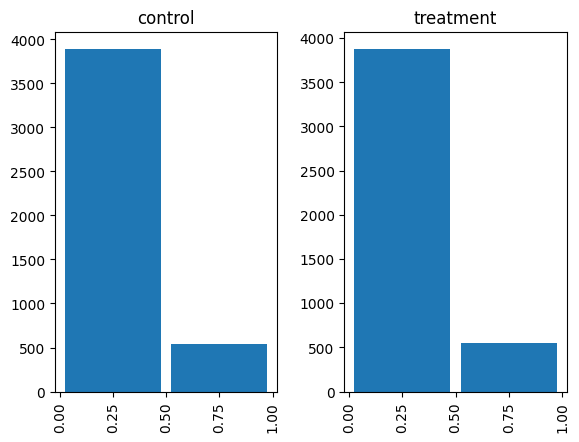

In [139]:
df.hist(column='converted', by='group', grid=False, bins=2, rwidth=0.9)
plt.show()

Для наглядності побудувати гістограму і бачимо, що різниці між групами мінімальна. Тому переходимо до більш глибшого аналізу застосовуючи довірчий інтервал біноміальної пропорції. Якщо інтервали не збігаються: це означає, що ми можемо з певним рівнем упевненості сказати, що один кращий за інший, таким чином надаючи достатньо доказів, щоб відхилити нульову гіпотезу.

In [149]:
df.groupby('group')['converted'].sum()

group
control      538
treatment    552
Name: converted, dtype: int64

In [154]:
p_hat = 538 / 4432
se = math.sqrt(p_hat * (1 - p_hat) / 4432)
z_critical = stats.norm.ppf(1 - (1 - 0.95) / 2)
margin_of_error = z_critical * se

lower_bound = p_hat - margin_of_error
upper_bound = p_hat + margin_of_error

print(f"Довірчий інтервал для групи control пропорції з {0.95*100:.0f}% довірчим рівнем: ({lower_bound:.7f}, {upper_bound:.7f})")

Довірчий інтервал для групи control пропорції з 95% довірчим рівнем: (0.1117752, 0.1310046)


In [155]:
p_hat = 552 / 4432
se = math.sqrt(p_hat * (1 - p_hat) / 4432)
z_critical = stats.norm.ppf(1 - (1 - 0.95) / 2)
margin_of_error = z_critical * se

lower_bound = p_hat - margin_of_error
upper_bound = p_hat + margin_of_error

print(f"Довірчий інтервал для групи treatment пропорції з {0.95*100:.0f}% довірчим рівнем: ({lower_bound:.7f}, {upper_bound:.7f})")

Довірчий інтервал для групи treatment пропорції з 95% довірчим рівнем: (0.1148272, 0.1342702)


Зауважимо, що довірчий інтервал для кожної групи міститься на відрізку [0,1], що означає, що обидві групи мають статистично значущу кількість успішних спостережень. Видно, що довірчий інтервал для treatment групи (0.1148272, 0.1342702) є трохи вищим за довірчий інтервал для control групи (0.1117752, 0.1310046). Це означає, що можливо, що тестова група має кращі результати, ніж контрольна група, але не можна з упевненістю стверджувати це, оскільки довірчі інтервали перетинаються. Отже, для зроблення висновку щодо ефективності тесту потрібно провести подальший аналіз.

Використаємо наступний метод Z-тест, який дозволяє оцінити статистичну значимість різниці між конверсіями у двох групах (контрольній і тестовій). Основна ідея полягає в порівнянні середніх значень конверсій в контрольній та тестовій групах та обчисленні z-статистики, яка відображає розмір різниці між середніми значеннями у стандартних одиницях. 

In [163]:
control_conversion = 538 / 4432
treatment_conversion = 552 / 4432

se = ((control_conversion * (1 - control_conversion)) / 4432 + (treatment_conversion * (1 - treatment_conversion)) /4432) ** 0.5
z_stat = (treatment_conversion - control_conversion) / se
p_value = 2 * (1 - norm.cdf(abs(z_stat)))

print("z-статистика: ", z_stat)
print("p-значення: ", p_value)

z-статистика:  0.4528062524271283
p-значення:  0.650688260990564


Оскільки наше значення p перевищує порогове значення α=0,05, ми не можемо відхилити нульову гіпотезу.
Це означає, що нова сторінка не краща за стару(немає суттєвих відмінностей). Тобто можемо зробити висновки, що не має сенсу у використанні нової сторінки.